In [1]:
import glob
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
#import mpld3 
import seaborn as sns
import palettable.colorbrewer.diverging as pld
import palettable.colorbrewer.sequential as pld2

import numpy as np
import pandas as pd
from sklearn import preprocessing

from scipy import integrate  
import scipy.signal as scipy
from scipy.optimize import curve_fit

# from numpy import diff
# from numpy import gradient
%matplotlib widget

In [2]:
plt.close('all')

In [3]:
## Plotting parameters

# palette = pld.RdYlGn_4_r
palette = pld.Spectral_10_r
# palette = pld.Spectral_3
# palette = pld2.YlOrRd_9
cmap = palette.mpl_colormap
transparency = 0.7
labelsize = 18
spinewidth = 2
fontsize = 26
legendsize = 13
fontweight = 'bold'
labelpad = 6
pad = 10
linewidth = 2.2
markersize = 6


In [4]:
## In the current working folder (cwd)
## Find the datafiles of .cal for best fitting
# cwd = os.getcwd()
cwd = '/Users/chenghunglin/Documents/20221228_DSE/CsPbBr3_ZnI2/16uL_min/'
cal_files = glob.glob(cwd + '/DFA_01/**.cal')
cal_files.sort()
print(*cal_files, sep = '\n')  ## Print one element per line


## Find the datafiles of 2D size distribution
mtx_files = glob.glob(cwd + '/DFA_01/**.mtx')
mtx_files.sort()
print(*mtx_files, sep = '\n')  ## Print one element per line


/Users/chenghunglin/Documents/20221228_DSE/CsPbBr3_ZnI2/16uL_min//DFA_01/CSpbBr3_ZnI2_16_20211114-183416_noHead_Best.cal
/Users/chenghunglin/Documents/20221228_DSE/CsPbBr3_ZnI2/16uL_min//DFA_01/CSpbBr3_ZnI2_16_20211114-183416_noHead_F_01.cal
/Users/chenghunglin/Documents/20221228_DSE/CsPbBr3_ZnI2/16uL_min//DFA_01/CSpbBr3_ZnI2_16_20211114-183416_noHead_F_02.cal
/Users/chenghunglin/Documents/20221228_DSE/CsPbBr3_ZnI2/16uL_min//DFA_01/CSpbBr3_ZnI2_16_20211114-183416_noHead_F_03.cal
/Users/chenghunglin/Documents/20221228_DSE/CsPbBr3_ZnI2/16uL_min//DFA_01/CsPbBr3_ZnI2_SIM_SPD#01.cal
/Users/chenghunglin/Documents/20221228_DSE/CsPbBr3_ZnI2/16uL_min//DFA_01/stage_best.cal
/Users/chenghunglin/Documents/20221228_DSE/CsPbBr3_ZnI2/16uL_min//DFA_01/CsPbBr3_mp-56762901_plot2D.mtx
/Users/chenghunglin/Documents/20221228_DSE/CsPbBr3_ZnI2/16uL_min//DFA_01/CsPbI3_mp-112076802_plot2D.mtx


In [5]:
## Read **_Best.cal into pandas dataframe
df0 = pd.read_csv(cal_files[0], header=None, skiprows=2, sep=' ')
df = df0.dropna(axis=1).rename(columns={0:'theta', 2:'obs', 8:'cal', 14:'cal1', 20:'cal2', 26:'bkg'})


## Read **_plot2D.mtx into pandas dataframe
df1 = []
for f in mtx_files:
    df_temp = pd.read_csv(f, skiprows=1, sep=' ', skipinitialspace=True)
    updated_labels = df_temp.columns.values.tolist()
    del updated_labels[0]
    updated_labels.append('None')
    df_temp.columns = updated_labels
    df1.append(df_temp)
    

# df1 = pd.read_csv(mtx_files[0], skiprows=1, sep=' ', skipinitialspace=True)
# updated_labels = df1.columns.values.tolist()
# del updated_labels[0]
# updated_labels.append('None')
# df1.columns = updated_labels

# df2 = pd.read_csv(mtx_files[1], skiprows=1, sep=' ', skipinitialspace=True)
# updated_labels = df2.columns.values.tolist()
# del updated_labels[0]
# updated_labels.append('None')
# df2.columns = updated_labels

In [6]:
df1[0]

,n_ab,n_c,Number_Frac.,Mass_Frac.,Diam[nm],Volume[nm^3],Mass[amu],Base_Diam.(e.c.)[nm],Height[nm],Lattice_Expan.[],OCC_ATOM_01,Biso_ATOM_01[A^2],OCC_ATOM_02,Biso_ATOM_02[A^2],OCC_ATOM_03,Biso_ATOM_03[A^2],OCC_ATOM_04,Biso_ATOM_04[A^2],None
0,26,1,0.000000,0.000000,10.302830,572.622340,1.567811e+06,29.513239,0.837037,0.000000,0.999973,7.274313,1.0,11.788217,1.0,1.729299,1.0,2.548912,NaN
1,25,1,0.000000,0.000000,10.036932,529.421540,1.449530e+06,28.378114,0.837037,0.000000,0.999973,7.274313,1.0,11.788217,1.0,1.729299,1.0,2.548912,NaN
2,24,1,0.000000,0.000000,9.767464,487.914890,1.335886e+06,27.242990,0.837037,0.000000,0.999973,7.274313,1.0,11.788217,1.0,1.729299,1.0,2.548912,NaN
3,23,1,0.000000,0.000000,9.494226,448.102390,1.226882e+06,26.107865,0.837037,0.000000,0.999973,7.274313,1.0,11.788217,1.0,1.729299,1.0,2.548912,NaN
4,22,1,0.000000,0.000000,9.216997,409.984040,1.122516e+06,24.972741,0.837037,0.000000,0.999973,7.274313,1.0,11.788217,1.0,1.729299,1.0,2.548912,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,4,36,0.000000,0.000000,9.767464,487.914890,1.335886e+06,4.540498,30.133332,0.000000,0.999973,7.274313,1.0,11.788217,1.0,1.729299,1.0,2.548912,NaN
968,3,36,0.000006,0.000051,8.062864,274.452130,7.514362e+05,3.405374,30.133332,0.999646,0.999973,7.274313,1.0,11.788217,1.0,1.729299,1.0,2.548912,NaN
969,2,36,0.000113,0.000402,6.153117,121.978720,3.339716e+05,2.270249,30.133332,0.999646,0.999973,7.274313,1.0,11.788217,1.0,1.729299,1.0,2.548912,NaN
970,1,36,0.001196,0.001063,3.876221,30.494681,8.349291e+04,1.135125,30.133332,0.999646,0.999973,7.274313,1.0,11.788217,1.0,1.729299,1.0,2.548912,NaN


In [7]:
global_mass_fraction = [0.40, 0.60]
df1[0]['norm_mass_frac'] = df1[0]['Mass_Frac.'] * global_mass_fraction[0]
df1[1]['norm_mass_frac'] = df1[1]['Mass_Frac.'] * global_mass_fraction[1]

m3 = df1[0]['norm_mass_frac'] + df1[1]['norm_mass_frac']
df1[0]['norm_mass_frac'].max()
df1[1]['norm_mass_frac'].max()

0.19260106200000002

'\n## Plot **.mtx as an inset 2D plot in ax1\nfrom mpl_toolkits.axes_grid.inset_locator import inset_axes, InsetPosition\n## Method 1:\nax2 = plt.axes(projection=\'3d\')\n#ax2 = plt.axes([0,0,1,1])\nip = InsetPosition(ax1, [0.45, 0.45, 0.45, 0.45])\nax2.set_axes_locator(ip)\n## Method 2:\nax2 = inset_axes(ax1, width="120%", height="120%",\n                   bbox_to_anchor=(0.45, 0.45, 0.45, 0.45),\n                   bbox_transform=ax1.transAxes, loc=10)\n'

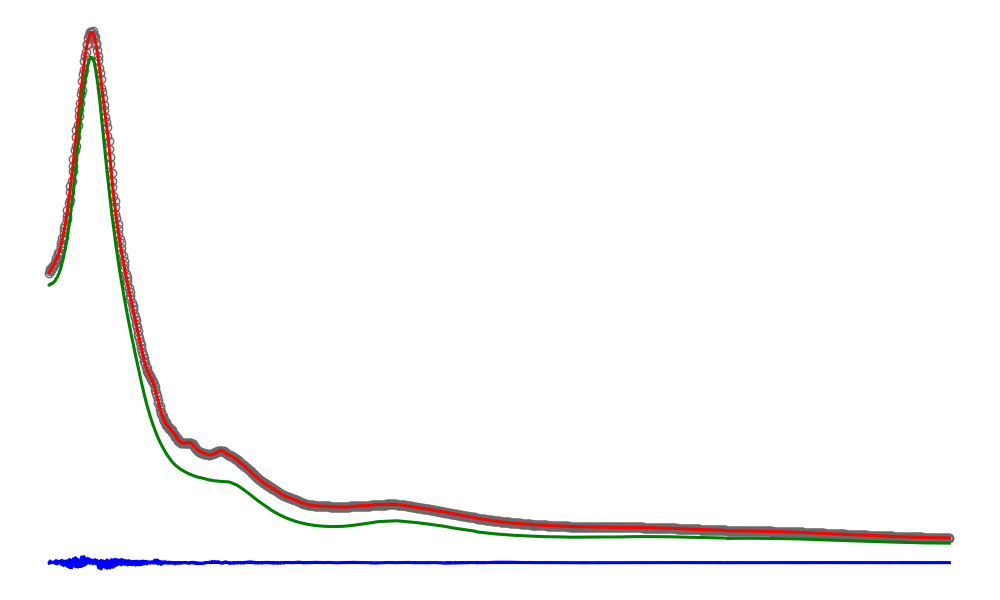

In [13]:
## Plot **_Best.cal
f1, ax1 = plt.subplots(1, 1, figsize = (10, 6), constrained_layout=True)
data_range = 1200 #648 # < 12 degree
ax1.plot(df.theta[:data_range], df.obs[:data_range], label='Observation', marker='o',color='dimgrey', fillstyle='none', linestyle='None', markersize=markersize)
ax1.plot(df.theta[:data_range], df.cal[:data_range], 'r-', label='DSE Simulation', linewidth=linewidth)
ax1.plot(df.theta[:data_range], df.bkg[:data_range], 'g-', label='Background', linewidth=linewidth)

y_offset = 1500
difference = df.obs - df.cal + y_offset
ax1.plot(df.theta[:data_range], difference[:data_range], 'b-', label='Difference', linewidth=linewidth)
ax1.hlines(y=0+y_offset, xmin=df.theta[0], xmax=df.theta[data_range], color='k', linestyle='-')

legend_properties = {'size':legendsize, 'weight':'bold'}
# ax1.legend(prop=legend_properties, bbox_to_anchor=(0.31, 0.30))

ax1.set_xticks([])
# ax1.tick_params(axis='x', direction='in', labelsize=labelsize-4)
#plt.setp(ax1.get_xticklabels(), fontweight="bold")
ax1.spines["bottom"].set_linewidth(spinewidth)
ax1.set_yticks([])
ax1.spines["left"].set_linewidth(spinewidth)
ax1.spines["top"].set_linewidth(spinewidth)
ax1.spines["right"].set_linewidth(spinewidth)

# ax1.set_xlabel('tth (degree)', fontsize=16, fontweight='regular')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

imag_name = 'ZnI2_16uL_min_DFA_01 no spines.png'
# plt.savefig(cwd+imag_name, dpi = 600,  transparent=True)

'''
## Plot **.mtx as an inset 2D plot in ax1
from mpl_toolkits.axes_grid.inset_locator import inset_axes, InsetPosition
## Method 1:
ax2 = plt.axes(projection='3d')
#ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax1, [0.45, 0.45, 0.45, 0.45])
ax2.set_axes_locator(ip)
## Method 2:
ax2 = inset_axes(ax1, width="120%", height="120%",
                   bbox_to_anchor=(0.45, 0.45, 0.45, 0.45),
                   bbox_transform=ax1.transAxes, loc=10)
'''

In [9]:
df1[0]['Mass_Frac.'].max()
# df1[1]['norm_mass_frac'].max()

0.031596792

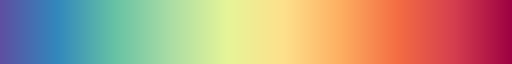

In [10]:
cmap

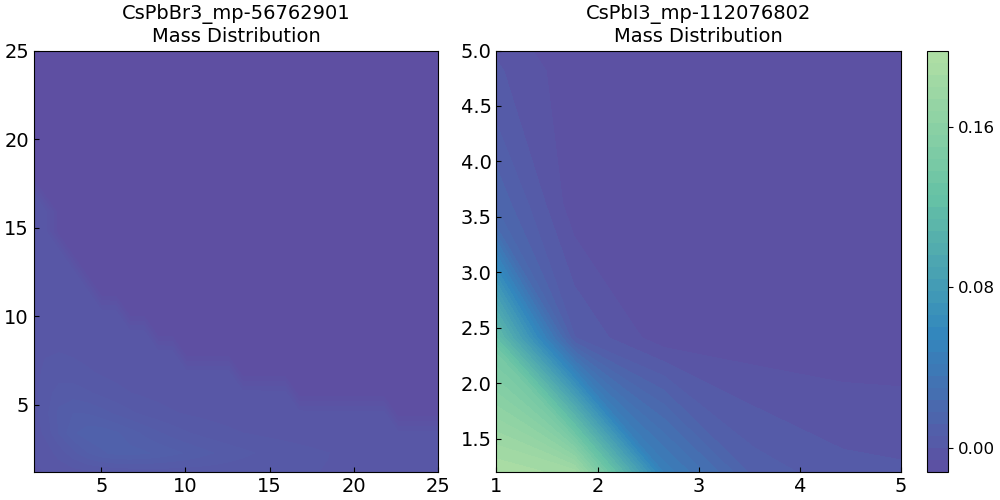

In [16]:
## Plot **.mtx as an 2D plot in ax2
f2, ax2 = plt.subplots(1, 2, figsize = (10, 5), gridspec_kw={'width_ratios': [1,1]}, constrained_layout=True)
# ax2.flatten()
titles = ['CsPbBr3_mp-56762901', 'CsPbI3_mp-112076802']
tick_step = [0.01, 0.08]

for i in range(len(df1)):
# for i in range(1):
    df_reshape = df1[i].pivot(index='Base_Diam.(e.c.)[nm]', columns='Height[nm]', values='norm_mass_frac')
    
    X = np.array(df_reshape.index)
    Y = np.array(df_reshape.columns)
    X, Y = np.meshgrid(Y, X)
    Z = np.array(df_reshape)
    Z[Z==0.0] = -0.01
    # cs = ax2[i].contourf(X, Y, Z, cmap=cmap)
    # cs = ax2[i].contourf(X, Y, Z, levels=36, cmap=cmap)
    cs = ax2[i].contourf(X, Y, Z, vmax = 0.6, levels=36, cmap=cmap)
    
    ax2[i].set_title(titles[i]+'\n'+'Mass Distribution', {'fontsize': 14, 'fontweight': 'normal'})
    #ax2[i].set_xticks([])
    ax2[i].tick_params(axis='both', direction='in', labelsize=labelsize-4)
    # ax2[i].set_yticks([])
    # ax2[i].tick_params(axis='y', direction='in', labelsize=labelsize-4)
    # ax2[i].set_zticks(np.arange(0.01, np.nanmax(Z), 0.02))
    # ax2[i].tick_params(axis='z', direction='in', labelsize=labelsize-4)


    # cbar = f2.colorbar(cs, shrink=1, aspect=20, ax=ax2[i])
    # cbar.set_ticks(np.arange(0, np.nanmax(Z), tick_step[i]))
    # cbar.ax.tick_params(labelsize=labelsize-6)


cbar = f2.colorbar(cs, shrink=1, aspect=20)
cbar.set_ticks(np.arange(0, np.nanmax(Z), tick_step[i]))
cbar.ax.tick_params(labelsize=labelsize-6)    

ax2[0].set_xlim(1, 25)   ## L_c
ax2[0].set_ylim(1.2, 25)   ## D_ab
    
ax2[1].set_xlim(1, 5)   ## L_c
ax2[1].set_ylim(1.2, 5)   ## D_ab

imag_name = 'ZnI2_16uL_min_DFA_01 size.png'
# plt.savefig(cwd+imag_name, dpi = 600,  transparent=True)

In [ ]:
## Plot **.mtx as an 3D plot in ax3
f3 = plt.figure(figsize = (10, 6))
ax3 = plt.axes(projection='3d')
# df_reshape = df1.pivot(index='n_ab', columns='n_c', values='Number_Frac.')
df_reshape = df1[0].pivot(index='Base_Diam.(e.c.)[nm]', columns='Height[nm]', values='Number_Frac.')

X = np.array(df_reshape.index)
Y = np.array(df_reshape.columns)
X, Y = np.meshgrid(Y, X)
Z = np.array(df_reshape)
Z[Z==0.0] = np.nan

surf = ax3.plot_surface(X, Y, Z, vmin=0, vmax=0.07, rstride=1, cstride=1, cmap=cmap)
cbar = f3.colorbar(surf, shrink=0.5, aspect=10)

ax3.set_xlim(0, 25)   ## L_c
ax3.set_ylim(2, 12)   ## D_ab
ax3.view_init(30, 30)


#ax3.set_xticks([])
ax3.tick_params(axis='x', direction='in', labelsize=labelsize-4)
#ax3.set_yticks([])
ax3.tick_params(axis='y', direction='in', labelsize=labelsize-4)
ax3.set_zticks(np.arange(0.01, np.nanmax(Z), 0.02))
ax3.tick_params(axis='z', direction='in', labelsize=labelsize-4)
cbar.set_ticks(np.arange(0.01, np.nanmax(Z), 0.02))
cbar.ax.tick_params(labelsize=labelsize-4)

imag_name = 'Size_dis_3D_02.png'
#plt.savefig(imag_name, dpi = 600,  transparent=True)

In [ ]:
df_reshape